# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)


# Fraud detection

## Introduction

### Requirements

* numpy>=1.13.3
* pandas>=0.21.0
* matplotlib>=1.5.1
* scikit-learn>=0.19.1

In [1]:
from math import log, floor, ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory data analysis

### Loading the data



In [2]:
train_filename = 'kaggle_data/train.csv'

In [3]:
data = pd.read_csv(train_filename)

In [4]:
data.head()

,id,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,585384,33,TRANSFER,858173.68,C1377622466,0.00,0.00,C19605810,2851522.11,3709695.79,0,0
1,2799765,217,PAYMENT,1871.41,C754521595,166974.00,165102.59,M1192749076,0.00,0.00,0,0
2,4037980,299,CASH_IN,457275.37,C2132467749,2680080.92,3137356.29,C964888645,481508.22,24232.86,0,0
3,2376123,192,PAYMENT,2286.72,C1339362342,32264.00,29977.28,M1771272073,0.00,0.00,0,0
4,5681109,397,CASH_OUT,415565.81,C264657244,32286.48,0.00,C327232824,823634.07,1239199.89,0,0


In [5]:
data.describe()

,id,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06
mean,3.181016e+06,2.433767e+02,1.797618e+05,8.339720e+05,8.551916e+05,1.101940e+06,1.226144e+06,1.292117e-03,2.357519e-06
std,1.836811e+06,1.423399e+02,6.029072e+05,2.890093e+06,2.925882e+06,3.414435e+06,3.685224e+06,3.592280e-02,1.535420e-03
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.589947e+06,1.550000e+02,1.338314e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.180644e+06,2.390000e+02,7.480644e+04,1.418500e+04,0.000000e+00,1.326494e+05,2.145384e+05,0.000000e+00,0.000000e+00
75%,4.771452e+06,3.350000e+02,2.087140e+05,1.072629e+05,1.441016e+05,9.433011e+05,1.112644e+06,0.000000e+00,0.000000e+00
max,6.362619e+06,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090096 entries, 0 to 5090095
Data columns (total 12 columns):
id                int64
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(4), object(3)
memory usage: 466.0+ MB


In [7]:
data.count()

id                5090096
step              5090096
type              5090096
amount            5090096
nameOrig          5090096
oldbalanceOrg     5090096
newbalanceOrig    5090096
nameDest          5090096
oldbalanceDest    5090096
newbalanceDest    5090096
isFraud           5090096
isFlaggedFraud    5090096
dtype: int64

In [8]:
# TODO: comment in markdown on the type of isFraud and isFlaggedFraud

In [9]:
np.unique(data['isFraud'])

array([0, 1])

In [10]:
np.unique(data['isFlaggedFraud'])

array([0, 1])

In [11]:
# TODO: comment in markdown on the inbalance between fraudulent and normal transactions

In [12]:
data.groupby('isFraud').count()[['id']]

,id
isFraud,
0,5083519
1,6577


In [13]:
# TODO: comment in markdown the correlation between isFraud and isFlaggedFraud; almost zero so there is no linear relationship between the variables

In [14]:
data['isFraud'].corr(data['isFlaggedFraud'])

0.042687080484791237

In [15]:
data_fraudulent = data[data['isFraud'] == 1]

In [16]:
# TODO: comment in markdown the graph of the amount of money per transaction

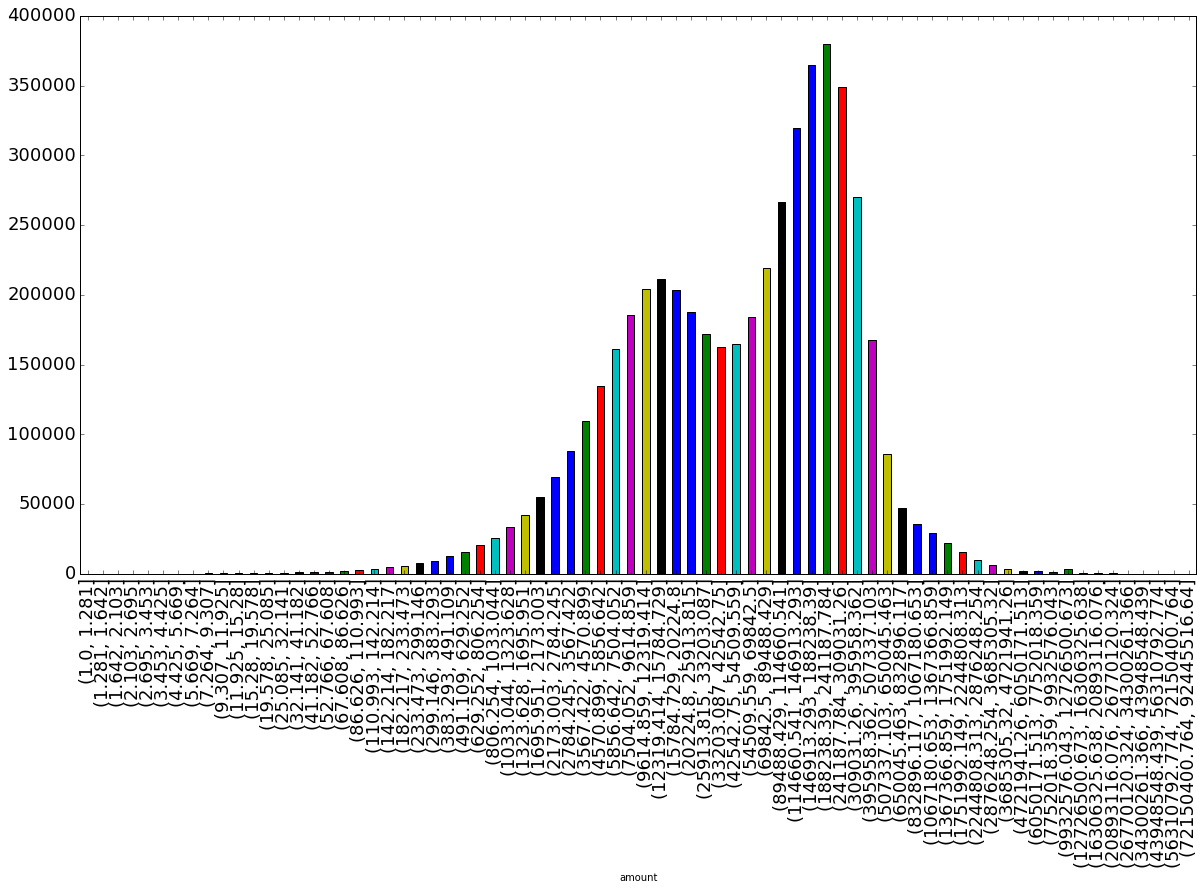

In [17]:
data['amount']\
    .groupby(pd.cut(data['amount'], np.logspace(0, log(data['amount'].max(), 10), num=75)))\
    .count()\
    .plot.bar(figsize=(20, 10), fontsize=18)

In [18]:
# TODO: comment in markdown the graph of the amount of money per transaction when it is a fraud

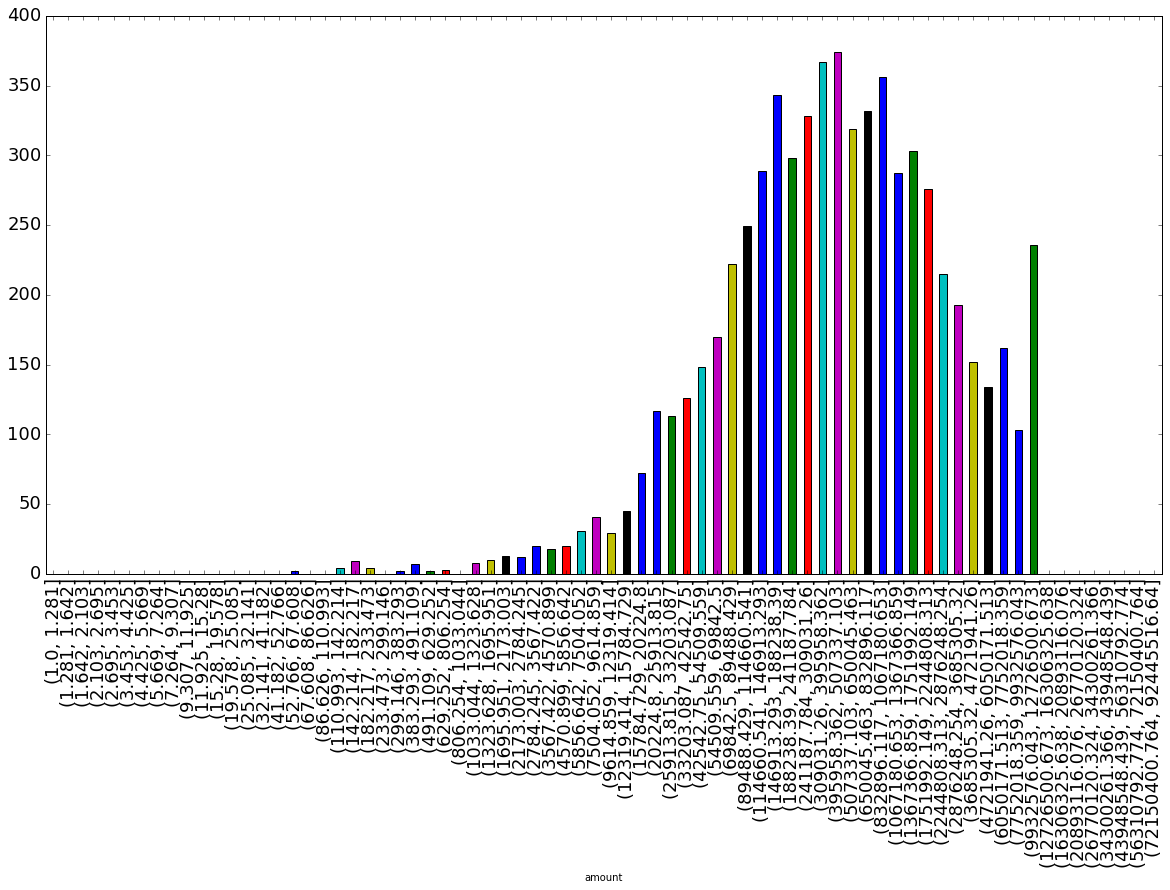

In [19]:
data_fraudulent['amount']\
    .groupby(pd.cut(data_fraudulent['amount'], np.logspace(0, log(data['amount'].max(), 10), num=75)))\
    .count()\
    .plot.bar(figsize=(20, 10), fontsize=18)

In [20]:
# TODO: comment in markdown the graph of the types of transactions vs the number of them

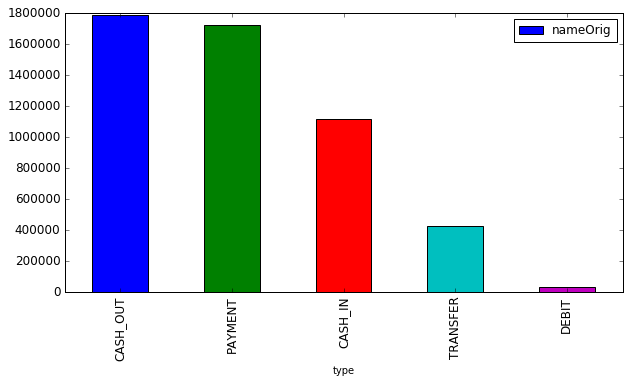

In [21]:
data.groupby('type').count()[['nameOrig']]\
    .sort_values('nameOrig', ascending=False)\
    .reset_index()\
    .plot.bar(x='type', y='nameOrig', figsize=(10, 5), fontsize=12);

In [22]:
# TODO: comment in markdown the graph of the types of transactions vs the number of them when the transactions are all frauds

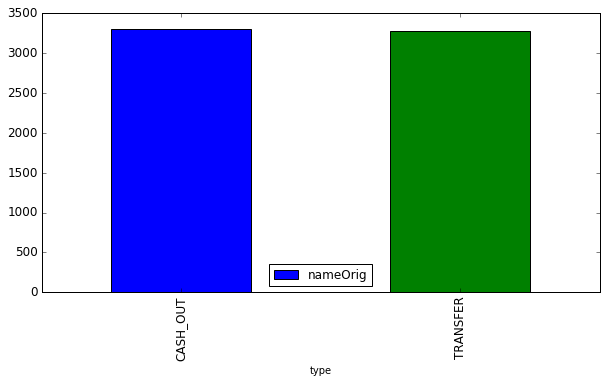

In [23]:
data_fraudulent.groupby('type').count()[['nameOrig']]\
    .sort_values('nameOrig', ascending=False)\
    .reset_index()\
    .plot.bar(x='type', y='nameOrig', figsize=(10, 5), fontsize=12);

In [24]:
# TODO: comment in markdown on the plot of the difference of the origin's account before and after the fraud

In [25]:
data_fraudulent['diff_orig'] = data_fraudulent['newbalanceOrig'] - data_fraudulent['oldbalanceOrg']

/home/pawello/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


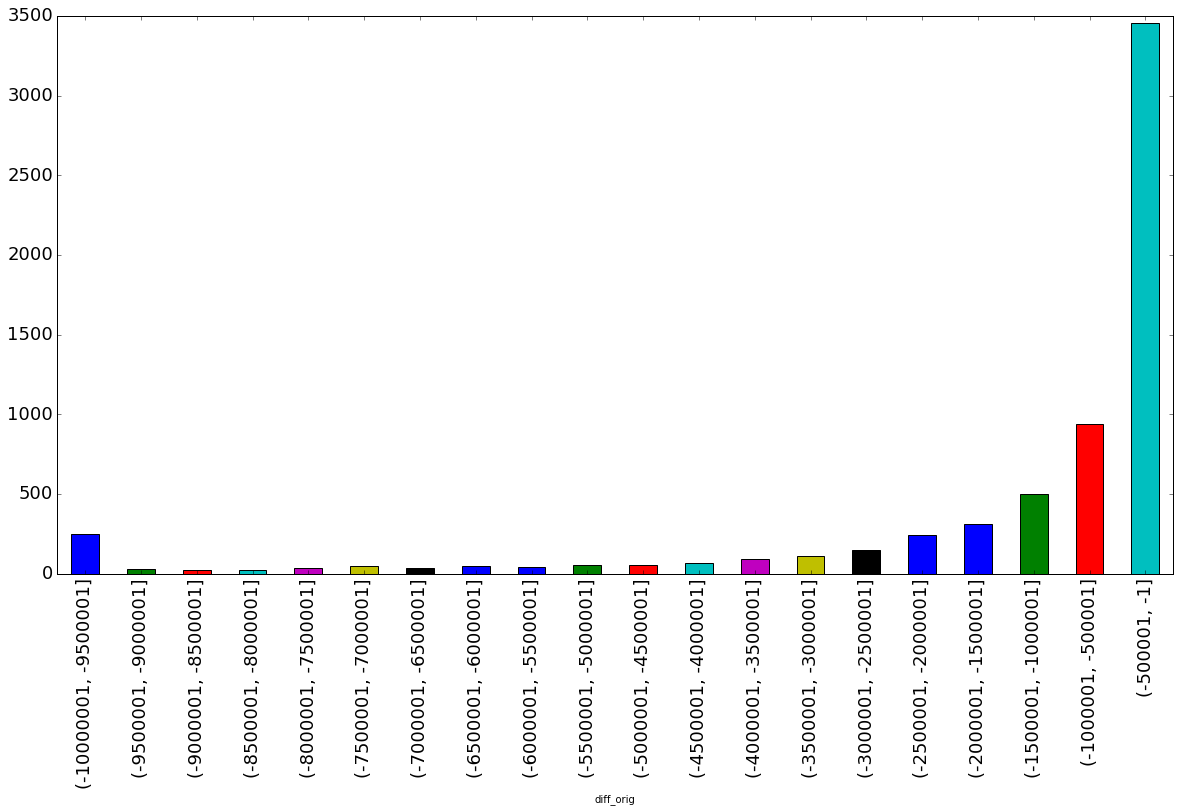

In [26]:
data_fraudulent['diff_orig']\
    .groupby(pd.cut(data_fraudulent['diff_orig'], range(floor(data_fraudulent['diff_orig'].min()), ceil(data_fraudulent['diff_orig'].max()), 500000)))\
    .count()\
    .plot.bar(figsize=(20, 10), fontsize=18)

In [27]:
# TODO: comment in markdown on the plot of the difference of the destination account before and after the fraud

In [28]:
data_fraudulent['diff_dest'] = data_fraudulent['newbalanceDest'] - data_fraudulent['oldbalanceDest']

/home/pawello/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


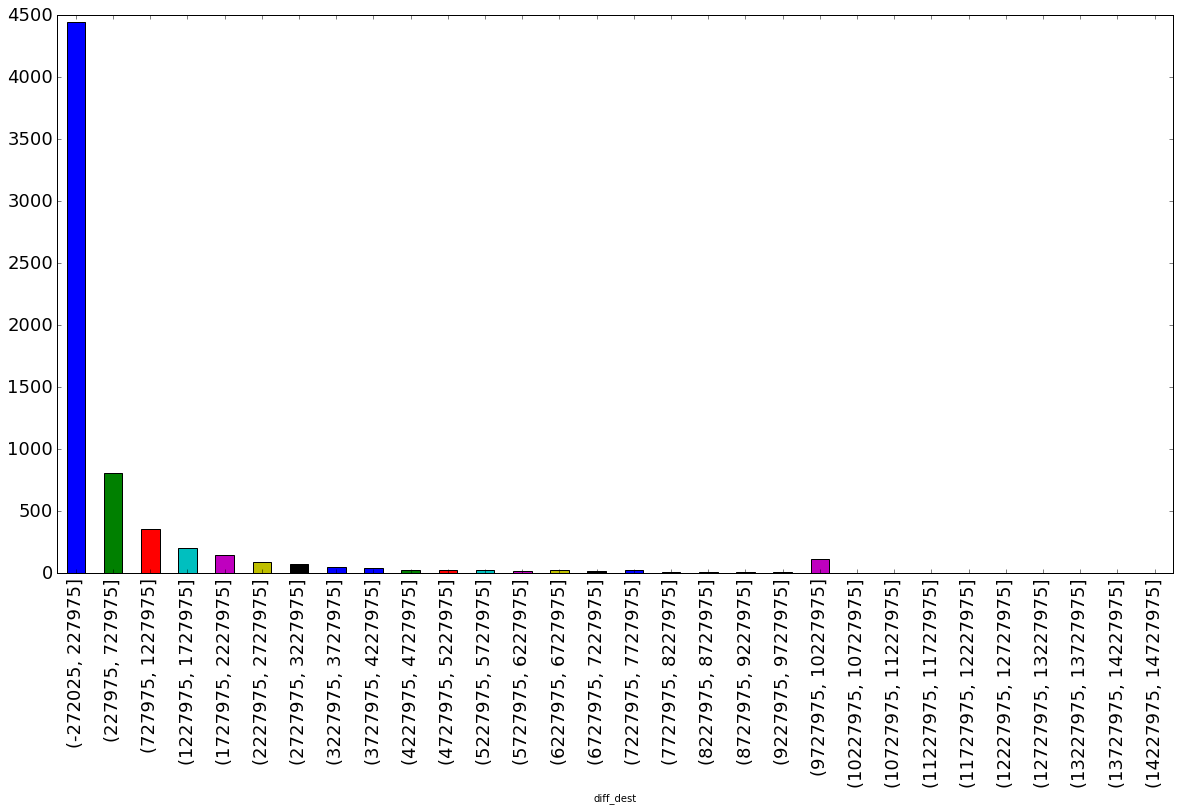

In [29]:
data_fraudulent['diff_dest']\
    .groupby(pd.cut(data_fraudulent['diff_dest'], range(floor(data_fraudulent['diff_dest'].min()), ceil(data_fraudulent['diff_dest'].max()), 500000)))\
    .count()\
    .plot.bar(figsize=(20, 10), fontsize=18)

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files,
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features), and  
* the class `Classifier` to predict the target.

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification.  

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [30]:
%%file submissions/starting_kit/feature_extractor.py
import numpy as np
from sklearn import preprocessing


class FeatureExtractor():
    def __init__(self):
        self.le = preprocessing.LabelEncoder()
        self.enc = preprocessing.OneHotEncoder()

    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        X_df = X_df.drop(['nameDest','nameOrig'],axis = 1)
        X_categorical = X_df.select_dtypes(include=[object])
        X_label = X_categorical.apply(self.le.fit_transform)
        self.enc.fit(X_label)
        dummy = self.enc.transform(X_label).toarray()
        X_df = X_df.drop(['type'],axis = 1)
        return np.concatenate((X_df.values, dummy), axis=1)

Overwriting submissions/starting_kit/feature_extractor.py


### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [31]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier(n_estimators=128, random_state=125)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Overwriting submissions/starting_kit/classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `classifier.py` and `feature_extractor.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [32]:
# Uncomment to run the test on the whole dataset
#!ramp_test_submission

You can use the `--quick-test` switch to test the notebook on the mock data sets in `data/`. Since the data is random, the scores will not be meaningful, but it can be useful to run this first on your submissions to make sure they run without errors.

In [33]:
!ramp_test_submission --quick-test

Testing Fraud detection
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	score  kappa  matthews  roc_auc  acc
	train  1.000     1.000     1.00  1.0
	valid  0.800     0.813     0.96  1.0
	test   0.907     0.910     0.98  1.0
CV fold 1
	score  kappa  matthews  roc_auc    acc
	train  1.000     1.000    1.000  1.000
	valid  0.731     0.759    0.959  0.999
	test   0.883     0.889    0.980  1.000
CV fold 2
	score  kappa  matthews  roc_auc  acc
	train  1.000     1.000     1.00  1.0
	valid  0.781     0.801     0.96  1.0
	test   0.900     0.905     0.98  1.0
CV fold 3
	score  kappa  matthews  roc_auc  acc
	train  1.000     1.000    1.000  1.0
	valid  0.809     0.824    0.979  1.0
	test   0.912     0.915    0.990  1.0
CV fold 4
	score  kappa  matthews  roc_auc    acc
	train  1.000     1.000    1.000  1.000
	valid  0.758     0.777    0.969  0.999
	test   0.890     0.894    0.985  1.000
CV fold 5
	score  kappa  matthews  roc_auc    acc


## Other models in the starting kit

You can also keep several other submissions in your work directory [`submissions`](/tree/submissions) and test them using
```
ramp_test_submission --submission <submission_name>
```
where `<submission_name>` is the name of the folder in `submissions/`.

## Submitting to [ramp.studio](http://ramp.studio)

If you are eligible, you can join the team at [ramp.studio](http://www.ramp.studio). If it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). 

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/kaggle_seguro/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/kaggle_seguro/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/fraud_detection/leaderboard).
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/fraud_detection/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation and test scores 
```
----------------------------
score           kappa        matthews         roc_auc          acc
train       1.0 ± 0.0       1.0 ± 0.0       1.0 ± 0.0    1.0 ± 0.0
valid  0.764 ± 0.0278  0.784 ± 0.0234  0.951 ± 0.0185  0.999 ± 0.0
test   0.893 ± 0.0107  0.898 ± 0.0098  0.975 ± 0.0093    1.0 ± 0.0
```
and bagged cross-validation and test scores
```
score  kappa
valid  0.764
test   0.859
```
This latter combines the cross-validation models pointwise on the validation and test sets, and usually leads to a better score than the mean CV score. The RAMP [leaderboard](http://www.ramp.studio/events/fraud_detection/leaderboard) displays this score.

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/fraud_detection/leaderboard)) is kappa statistic ("kappa"), so the line that is relevant in the output of `ramp_test_submission` is `kappa valid = 0.764`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Fraud detection notebook).